# STDSR23 - Assignment-01

> Danis Alukaev [@AlukaevDanis](https://t.me/AlukaevDanis) B19-DS-01

# Quantile implementation

February 2023

## Assignment description

* Obtain the research paper titled ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf)

* Select and implement one of the methods discussed in the paper, following good coding style and with appropriate comments. Your algorithm can be based on `BasicQuantileAlgorithm` class. In that case, your main implementation is in the `compute_quantile` function.
* Prepare a report that includes
    * A detailed explanation of the selected algorithm
    * A listing of the pros and cons of the chosen algorithm
* Test your implementation. More on that below in section `Test`.
* Submit Jupyter Notebook *.ipynb* to the Moodle

Note: Code style, comments, and overall organization of the report will be
taken into account in the grading process.


## Abstract implementation

Can be used as a basic class for your implementation

In [1]:
from typing import List

class BasicQuantileAlgorithm:
    """
    Abstract class for quantile computing algorithm
    """
    
    def __init__(self) -> None:
        """
        Initializer for algorithm
        """
    
    def compute_quantile(self, q) -> float:
        """
        Implementation of some quantile algorithm
        """
        raise NotImplementedError('compute_quantile is not implemented')
    
    def compute(self, q) -> float:
        assert 0.0 <= q <= 1.0, f"q should be in [0;1]. Got {q}"
        """
        Compute the q-th quantile
        
        Hides implementation of _compute_quantile. 
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return self.compute_quantile(q)
    
    # NOTE: multi_compute is just a basic function
    # for computing multiple quantile with one function call. 
    # This can be modified, so that multiple quantiles
    # calculation become efficient. 
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return [self.compute(q) for q in qs]

This is just an example of the algorithm implementation.

In [2]:
import numpy as np

class NumpyQuantileAlgorithm(BasicQuantileAlgorithm):
    """
    Example of quantile algorithm
    
    This algorithm implementation is 
    based on the numpy.quantile. 
    """
    def __init__(self):
        """
        Initializer of the class. 
        
        It initializes self.data with empty list
        """
        self.data = []
    
    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.data.append(item)
    
    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        self.data += items
    
    def compute_quantile(self, q) -> float:
        """
        Compute the q-th quantile
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return np.quantile(self.data, q)
    
    # NOTE: Here, for multi_compute we
    # can just call the same function
    # compute_quantile, because it could
    # take a vector of multiple quantiles.
    # This is more efficient, than basic 
    # function call, because of the 
    # vectorized implementation.
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return list(self.compute_quantile(qs))

In [3]:
stream = list(np.random.randint(100, size=10000))

In [4]:
nqa = NumpyQuantileAlgorithm()
nqa.add_multiple_items(stream)
nqa.compute(0.9)

89.0

For this assignment I have implemented an algorithm from the paper _"Approximate medians and other quantiles in one pass and with limited memory"_ by Manku, Rajagopalan, and Lindsay [available online](https://dl.acm.org/doi/pdf/10.1145/276305.276342). In the survey of approximate quantile computation this algorithm was given acronym MRL98 and categorized as deterministic suitable for streaming model.

In [5]:
import math

INF = math.inf

Authors of the paper extensively use term "buffer" and ofter refer to its properties in the manuscript. In my implementation I thereby will also use `Buffer` abstraction to design the proposed algorithm.

In [6]:
class Buffer:

    def __init__(self, k):
        """
        Initializer of the class.

        Set up default values to attributes of a buffer:
        list of elements, weight, label (either 'empty' of 'full'),
        and associated level.

        :param k: size of buffer
        """
        self.k = k
        self.attribute_init__()
    
    def attribute_init__(self):
        self.elements = list()
        self.weight = -1
        self.label = "empty"
        self.level = -1

    def populate(self, elements):
        """
        Populates buffer with a given elements.
        
        If capacity of buffer is greater than number of 
        given elements, it supplements list with equal 
        number of -inf and +inf values.

        :param elements: list of values to store
        """
        assert len(elements) <= self.k
        deficit = self.k - len(elements)
        _elements = list(elements)
        _elements += [-INF] * (deficit // 2) 
        _elements += [INF] * (self.k - len(_elements))
        self.elements = _elements
    
    def change_label(self, label):
        """
        Changes label of the buffer to a given.

        :param label: either 'empty' or 'full'
        """
        assert label in ["empty", "full"]
        self.label = label
    
    def assign_weight(self, weight):
        """
        Changes weight of the buffer to a given.

        :param weight: positive integer
        """
        assert isinstance(weight, int) and weight > 0
        self.weight = weight
    
    def assign_level(self, level):
        """
        Changes level of the buffer to a given.

        :param level: non-negative integer
        """
        assert isinstance(level, int) and level >= 0  
        self.level = level

    def __str__(self) -> str:
        s = f"elements: {self.elements}\n"
        s += f"weight: {self.weight}\n"
        s += f"label: {self.label}\n"
        s += f"level: {self.level}\n"
        return s

Following class represents the MRL98 algorithm. Notice that it follows an interface proposed in the original paper, i.e., the policy implemented based on three methods `NEW`, `COLLAPSE`, `OUTPUT`.

In [7]:
class MrlQuantileAlgorithm(BasicQuantileAlgorithm):

    def __init__(self, b, k, materialize=True):
        """
        Initializer of the class.

        :param b: number of buffers
        :param k: number of elements in buffer
        :param materialize: extend list physically on disk
        """
        super().__init__()
        self.b = b
        self.k = k
        self.materialize = materialize

        self.stream = list()
        self.attribute_init__()
    
    def attribute_init__(self):
        self.even_weight_term = 0
        self.buffers = [Buffer(self.k) for _ in range(self.b)]

    def add_item(self, item):
        self.stream.append(item)
    
    def add_multiple_items(self, items):
        self.stream += items
    
    def new(self, buffer, stream) -> list:
        """
        Operation NEW.

        Populates a given buffer with next k elements from 
        the input sequence.

        :param buffer: buffer to be populated
        :param stream: pending elements
        :return: residual elements from stream 
        """
        assert buffer.label == "empty" and len(stream) > 0
        elements = stream[:self.k]

        buffer.populate(elements)
        buffer.change_label("full")
        buffer.assign_weight(1)

        residual = stream[self.k:]
        
        return residual
    
    def collapse(self, buffers) -> Buffer:
        """
        Operation COLLAPSE.

        For a given set of buffers X (2 and more) generates a single buffer Y.
        Weight of Y is set to be the sum of weights of all buffers in X.
        All buffers are extended by copying each element in buffer w times, 
        where w is the weigth of the buffer element belongs to. Further buffers are
        merged and sorted, which allows to retrieve k equidistant elements. 
        Finally, buffers are set to be empty and one of them adopts retrieved elements.

        :param buffers: buffers to be collapsed
        :return: new buffer
        """
        assert len(buffers) >= 2 and all([b.label == "full" for b in buffers])

        new_buffer = Buffer(self.k)
        new_buffer.assign_weight(sum([b.weight for b in buffers]))
        
        offset_term = 1
        weight_is_even = new_buffer.weight / 2 == 0
        if weight_is_even:
            offset_term = self.even_weight_term
            self.even_weight_term = 2 - self.even_weight_term
        offset = int((new_buffer.weight + offset_term) / 2 - 1)
        
        _elements = list()
        if self.materialize:
            merged_elements = list()
            for b in buffers:
                merged_elements += b.elements * b.weight
            merged_elements = sorted(merged_elements)
            _elements = [merged_elements[j * new_buffer.weight + offset] for j in range(self.k)]
        else:
            elements_weight_pairs = sorted([[e, b.weight] for b in self.buffers for e in b.elements], key=lambda x: x[0])
            for i in range(1, len(elements_weight_pairs)):
                elements_weight_pairs[i][1] += elements_weight_pairs[i - 1][1]
            positions = [j * new_buffer.weight + offset for j in range(self.k)]
            
            cur_position_idx = 0
            for idx in range(len(elements_weight_pairs)):
                if cur_position_idx >= len(positions):
                    break
                cur_position = positions[cur_position_idx]
                if cur_position <= elements_weight_pairs[idx][1] - 1:
                    _elements.append(elements_weight_pairs[idx][0])
                    cur_position_idx += 1
              
        new_buffer.populate(_elements)
        new_buffer.change_label("full")

        return new_buffer

    def output(self, buffers, q):
        """
        Operation OUTPUT.

        Performed before termination of algorithm. For a given set of 
        buffers outputs a single element that corresponds to approximate
        quantile of the dataset. 
        Similar to COLLAPSE operation extends buffer by copying elements, 
        merges them, and sums up weights of each buffer. The position of
        quantile is computed as floor(q * k * W).
        
        :param buffers: buffers to be used for quantile approximation
        :param q: q-th quantile
        :return: quantile approximation
        """
        assert len(buffers) >= 2 and all([b.label == "full" for b in buffers])

        merged_elements = list()
        W = 0
        for b in buffers:
            merged_elements += b.elements * b.weight
            W += b.weight
        merged_elements = sorted(merged_elements)

        position = math.floor(q * self.k * W) - 1
        approximate_quantile = merged_elements[position]

        return approximate_quantile
    
    def __policy(self):
        """
        Tree-structure trigger strategy.

        Each buffer possesses attribute level. Let l be the 
        smallest level among the buffer. Thus, consider following cases:
        1. One empty buffer: NEW + assign level l
        2. At least two empty buffers: NEW + assign level 0
        3. No empty buffers: COLLAPSE on buffers with l + assign level l+1 
        """
        stream = self.stream

        while len(stream) > 0:
            empty_buffers = [b for b in self.buffers if b.label == "empty"]

            if len(empty_buffers) >= 2:
                for buffer in empty_buffers:
                    stream = self.new(buffer, stream)
                    buffer.assign_level(0)
                continue

            l = min([b.level for b in self.buffers if b.label == "full"])
            
            if len(empty_buffers) == 1:
                stream = self.new(empty_buffers[0], stream)
                empty_buffers[0].assign_level(l)
            
            elif len(empty_buffers) == 0:
                buffers_to_collapse = [(i, b) for i, b in enumerate(self.buffers) if b.label == "full" and b.level == l]
                new_buffer = self.collapse([b for i, b in buffers_to_collapse])
                [self.buffers[i].attribute_init__() for i, _ in buffers_to_collapse]
                self.buffers[buffers_to_collapse[0][0]] = new_buffer
                new_buffer.level = l + 1
    
    def compute_quantile(self, q) -> float:
        self.attribute_init__()
        self.__policy()
        return self.output(self.buffers, q)

    def __str__(self) -> str:
        s = str()
        for i in range(self.b):
            s += f"Buffer #{i}\n"
            s += str(self.buffers[i]) + "\n" 
        return s

In [8]:
BUFFERS = 10
CAPACITY = 5

mrl = MrlQuantileAlgorithm(BUFFERS, CAPACITY)
mrl.add_multiple_items(stream)
mrl.compute(0.9)

88

### Report

This jupyter notebook contains implementation of the algorithm proposed in _"Approximate Medians and other Quantiles in One Pass and with Limited Memory"_ by Manku, Rajagopalan, and Lindsay in 1998 (MRL98). 

The objective of MRL98 algorithm is to compute ε-approximate φ-quantile for a dataset of size N with a single pass and low memory costs. Remarkably, the algorithm was formulated in a form of a framework comprised of three operations: `NEW`, `COLLAPSE`, and `OUTPUT`, which will be examined in further sections.

To reduce the memory required by algorithm authors suggest using `b` buffers of size `k`, which thereby will maintain a memory footprint of `bk` elements. In fact, the entire framework is parametrized by these two integers. Each buffer is also associated with a so-called "weight" representing the relative number of input elements captured by the buffer. Buffers carry its state: either "empty" of "full".


#### `NEW` operation

__Prerequisites:__ at least one buffer is empty, input sequence is not empty.

`NEW` populates a new buffer with next `k` elements from the input sequence. Marks buffer as "full" and assigns weight of 1.

If capacity of buffer is greater than number of given elements, it supplements list with equal number of -∞ and +∞ values.


#### `COLLAPSE` operation
__Prerequisites:__ at least two buffers are full.

For a given set of buffers `COLLAPSE` generates a single buffer. Weight of output buffer is set to be the sum of weights of all input buffers. All buffers are extended by copying each element in buffer w times, where w is the weigth of the buffer element belongs to. Further buffers are merged and sorted, which allows to retrieve k equidistant elements. Finally, all but one are set to be empty and the latter adopts retrieved elements.


#### `OUTPUT` operation
__Prerequisites:__ all buffers are full.

`OUTPUT` is performed before termination of algorithm. For a given set of buffers outputs a single element that corresponds to approximate quantile of the dataset. Similar to COLLAPSE operation extends buffer by copying elements, merges them, and sums up weights of each buffer. The position of quantile is computed as floor(q * k * W).

#### Trigger strategy

While designing a trigger strategy to invoke `COLLAPSE` operation, authors got inspired by tree-like structure.

Each buffer possesses attribute level. Let l be the 
smallest level among the buffer. Thus, consider following cases:
1. One empty buffer: NEW + assign level l
2. At least two empty buffers: NEW + assign level 0
3. No empty buffers: COLLAPSE on buffers with l + assign level l+1 

#### Intuition

From my perspective, the intuition behind the algorithm can be formulated as follows: we aim to continuously project the original dataset into a lower dimension and at the same time preserve properties of its distribution. Consequently, even though the augmented data is far smaller than the original one, it still informative enough to approximate the quantile from the data.

#### Pros and cons

__Pros:__ 
1. Reduced memory usage: the algorithm stores footprint of `bk` elements instead of the entire dataset.
2. The algorithm is deterministic, so that the results can always be replicated. 
3. Applicable to streaming models rather than disk-resident data.

__Cons:__ 
1. The algorithm is not applicable when length of a data stream `N` is uncertain.

### Comparison

In [9]:
import time
from sys import getsizeof
import matplotlib.pyplot as plt

In [10]:
sample_sizes = [10, 100, 1_000, 5_000, 10_000, 25_000, 50_000, 75_000, 100_000]
n_repetitions = 5

metrics = dict(
    time = dict(
        numpy = {s: [] for s in sample_sizes},
        mrl98 = {s: [] for s in sample_sizes}
    ),
    space_delta = {s: [] for s in sample_sizes}
)

for sample_size in sample_sizes:
    for i in range(n_repetitions):
        stream = list(np.random.randint(100, size=sample_size))
        
        nqa = NumpyQuantileAlgorithm()
        nqa.add_multiple_items(stream)

        buffer_size = max(1, int(0.2 * sample_size / 5))
        mrl = MrlQuantileAlgorithm(4, buffer_size)
        mrl.add_multiple_items(stream)

        quantile = np.random.random_sample()

        start_t = time.time()
        nqa.compute(quantile)
        metrics["time"]["numpy"][sample_size].append(time.time() - start_t)

        start_t = time.time()
        mrl.compute(quantile)
        metrics["time"]["mrl98"][sample_size].append(time.time() - start_t)

        metrics["space_delta"][sample_size].append(getsizeof(nqa) - getsizeof(mrl))

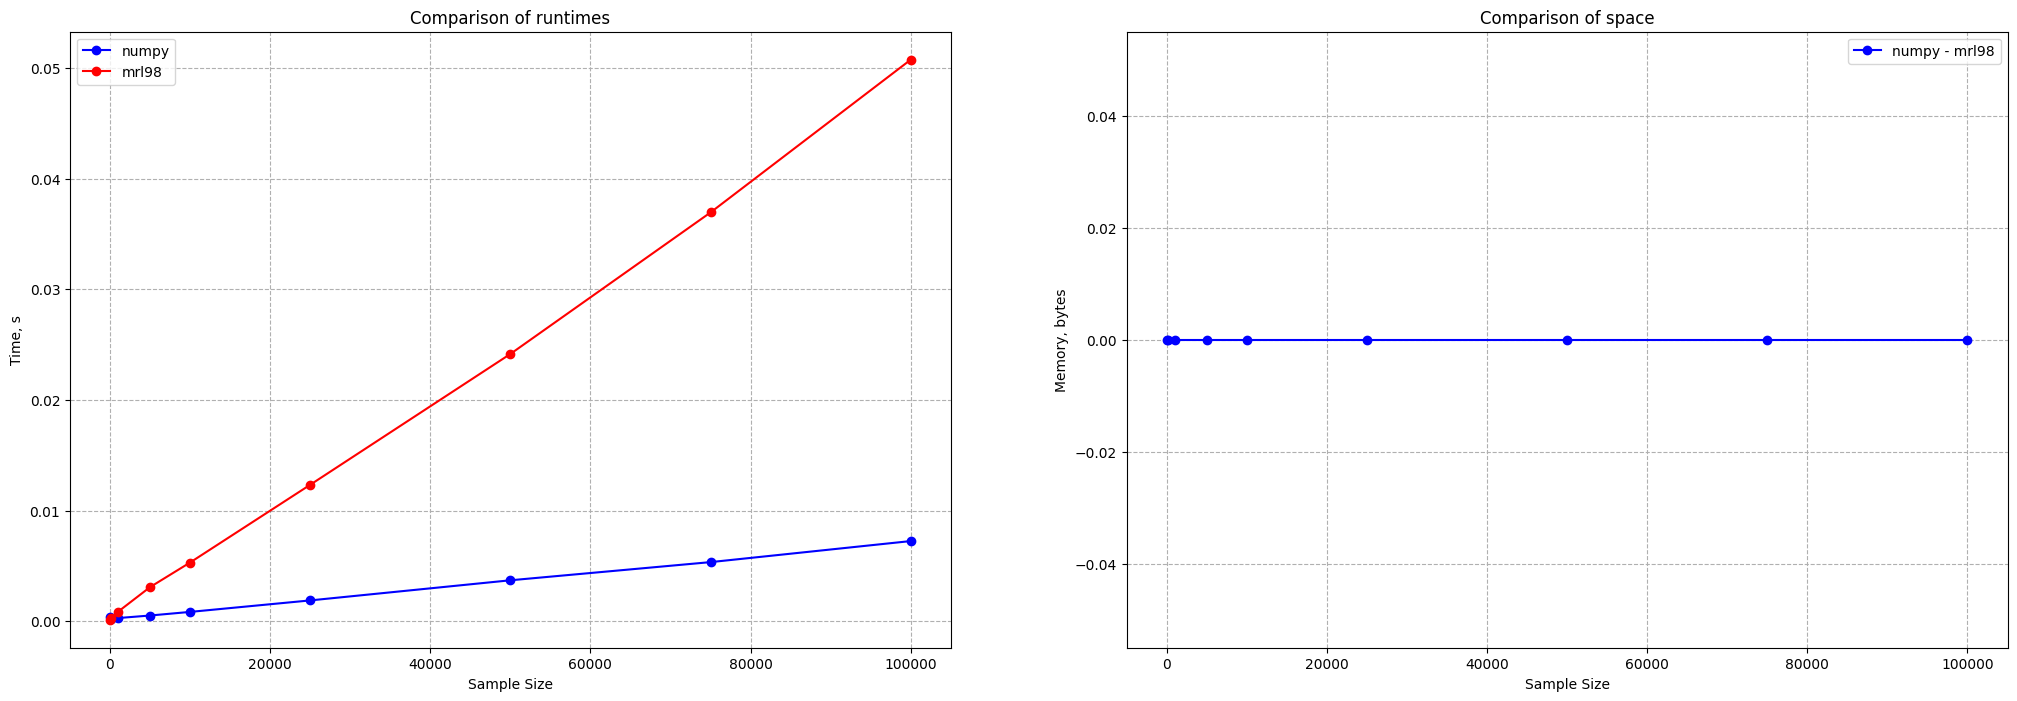

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(25, 8)
ax1.set_title(f"Comparison of runtimes")
ax1.grid(linestyle='--')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Time, s')
ax1.plot(np.array(sample_sizes), np.array([np.array(metrics["time"]["numpy"][s]).mean() for s in sample_sizes]), '-o', label='numpy', c='b')
ax1.plot(np.array(sample_sizes), np.array([np.array(metrics["time"]["mrl98"][s]).mean() for s in sample_sizes]), '-o', label='mrl98', c='r')
ax1.legend()

ax2.set_title(f"Comparison of space")
ax2.grid(linestyle='--')
ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Memory, bytes')
ax2.plot(np.array(sample_sizes), np.array([np.array(metrics["space_delta"][s]).mean() for s in sample_sizes]), '-o', label='numpy - mrl98', c='b')
ax2.legend()

plt.show() 

As you can see, implementation of MRL98 algorithm is significantly slower than the `numpy` implementation. Remarkably, we can see that difference between runtimes increases as sample size becomes greater. Both algorithms tend to occupy nearly the same amount of space, which clearly can be seen on the graph.

## Test

Here you need to show that your algorithm is working properly.
1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution. 

2. Perform the same experiment with any other continuous distribution (exponential, logistic, etc.)

In [12]:
from scipy.stats import norm, expon

#### Normal distribution

In [13]:
sample_sizes = [1000, 5000, 10000, 25000, 50000, 75000, 100000, 200000, 500000, 750000, 1000000]

deltas = list()
for sample_size in sample_sizes:
    normal_sample = list(np.random.normal(size=sample_size))
    buffer_size = max(1, int(0.2 * sample_size / 5))
    mrl = MrlQuantileAlgorithm(5, buffer_size)
    mrl.add_multiple_items(normal_sample)
    quantile = mrl.compute(0.95)
    deltas.append(quantile - norm.ppf(0.95))

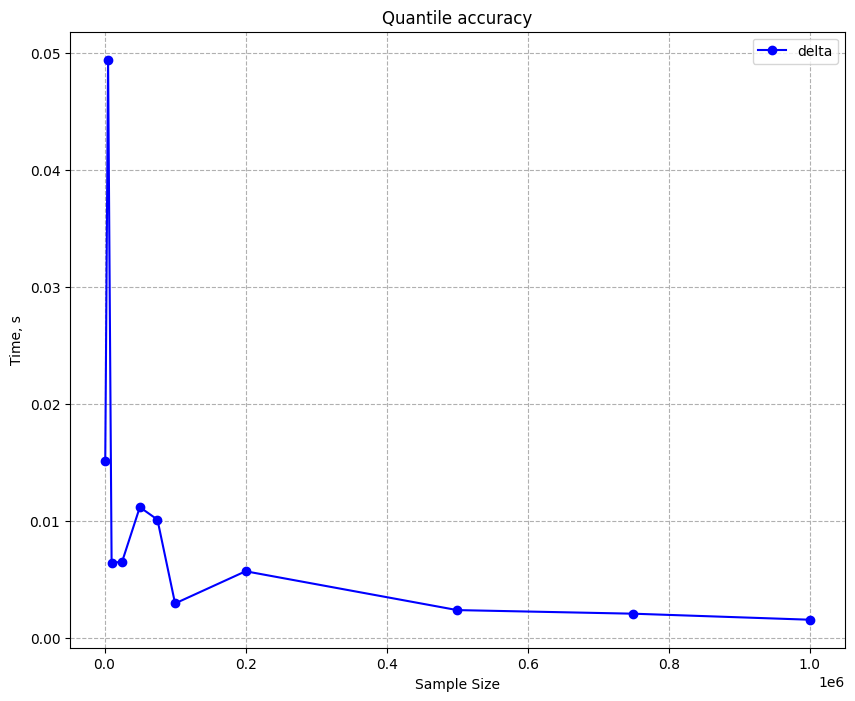

In [14]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 8)
ax1.set_title(f"Quantile accuracy")
ax1.grid(linestyle='--')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Time, s')
ax1.plot(np.array(sample_sizes), np.abs(np.array(deltas)), '-o', label='delta', c='b')
ax1.legend()
plt.show()

In [15]:
deltas

[0.015134187388459619,
 0.049428547368223885,
 -0.006378800946955421,
 0.006518533481625788,
 0.011165013595002549,
 0.01009963534668512,
 -0.002932122137074167,
 0.00568411220225129,
 0.0023635502982568557,
 0.002055446266286509,
 0.0015402524187322353]

Wow, it's indeed decreasing!

#### Exponential distribution

In [21]:
sample_sizes = [1000, 5000, 10000, 25000, 50000, 75000, 100000, 200000, 500000, 750000, 1000000]

deltas = list()
for sample_size in sample_sizes:
    exp_sample = list(np.random.exponential(size=sample_size))
    buffer_size = max(1, int(0.2 * sample_size / 5))
    mrl = MrlQuantileAlgorithm(5, buffer_size)
    mrl.add_multiple_items(exp_sample)
    quantile = mrl.compute(0.95)
    deltas.append(quantile - expon.ppf(0.95))

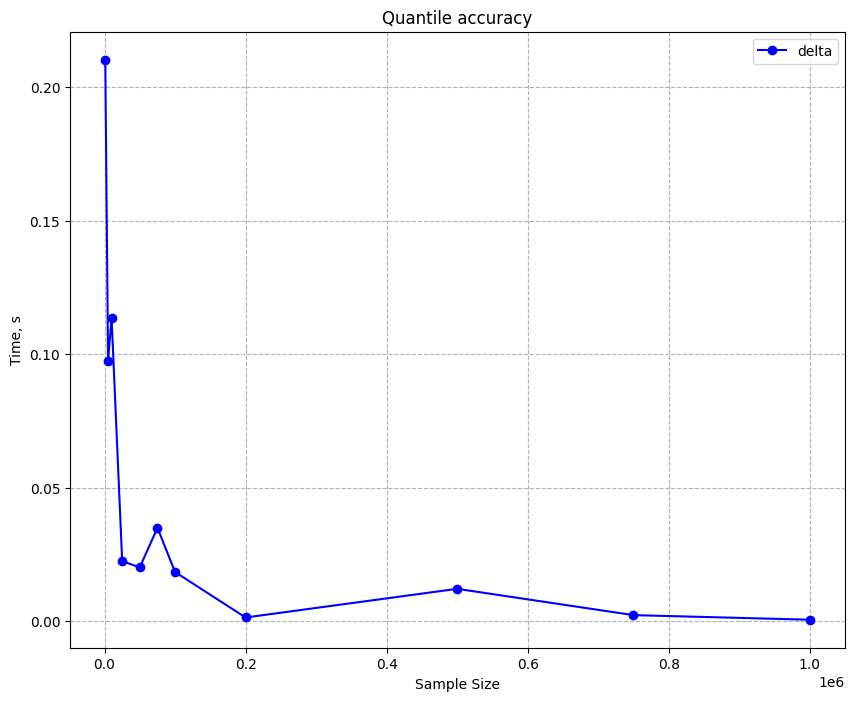

In [22]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 8)
ax1.set_title(f"Quantile accuracy")
ax1.grid(linestyle='--')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Time, s')
ax1.plot(np.array(sample_sizes), np.abs(np.array(deltas)), '-o', label='delta', c='b')
ax1.legend()
plt.show()

In [23]:
deltas

[-0.21030839835105564,
 -0.09765374721601328,
 -0.11357859276913596,
 -0.022481618451397622,
 0.020180730512982414,
 0.03500000639728462,
 0.018418744645161578,
 0.00140157504859717,
 -0.012139031368458841,
 0.002285834058845637,
 0.0005657177940476821]

We can observe similar behaviour also with exponential distribution!

#### Main purpose of algorithm

Key objective of algorithm is to reduce required memory by utilizing buffers. Let's consider extreme case of a data stream with 1 million points!

In [26]:
BUFFERS = 10
CAPACITY = 4000

stream = list(np.random.randint(100, size=1_000_000))

mrl = MrlQuantileAlgorithm(4, CAPACITY)
mrl.add_multiple_items(stream)
quantile = mrl.compute(0.5)
print(f"Quantile approximated: {quantile}")

Quantile approximated: 50


It managed to compute the quantile pretty accurately. Note that memory footprint is only 40k instead of 10 millions!